Let's use the classic Iris data to do some machine learning.

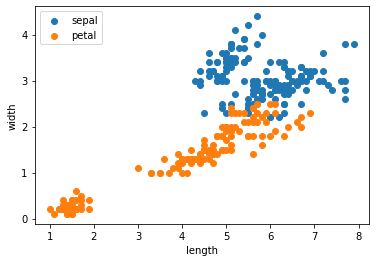

In [26]:
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

iris = datasets.load_iris() 
df = pd.DataFrame(iris.data, columns=iris.feature_names) #God forbid we just use an array
plt.scatter(df["sepal length (cm)"], df["sepal width (cm)"], label="sepal")
plt.scatter(df["petal length (cm)"], df["petal width (cm)"], label="petal")
plt.xlabel("length")
plt.ylabel("width")
plt.legend();

In [58]:
from sklearn.svm import SVC ##support vector classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

X_iris = iris.data
y_iris = iris.target

X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.8, random_state=42)

classifiers = {
    "SVD":SVC(),
    "SVCrbf":SVC(kernel="rbf"),
    "KNN":KNeighborsClassifier(n_neighbors=3),
    "DTree":DecisionTreeClassifier(),
    "GNB":GaussianNB()
}
for k,v in classifiers.items(): v.fit(X_train, y_train);

In [59]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
for k, v in classifiers.items():
    y_pred = v.predict(X_test)
    print( k, "\t:: Accuracy {}, Balanced Accuracy {}".format( 
        accuracy_score(y_test, y_pred), 
        balanced_accuracy_score(y_test, y_pred)))

SVD 	:: Accuracy 0.9333333333333333, Balanced Accuracy 0.9302744039586145
SVCrbf 	:: Accuracy 0.9333333333333333, Balanced Accuracy 0.9302744039586145
KNN 	:: Accuracy 0.975, Balanced Accuracy 0.9741340530814214
DTree 	:: Accuracy 0.9333333333333333, Balanced Accuracy 0.930949167791273
GNB 	:: Accuracy 0.95, Balanced Accuracy 0.9484930274403959


So is KNN really the best? What if we happened to pick a different train/test split?

In [60]:
classifiers = {
    "SVD":SVC(),
    "SVCrbf":SVC(kernel="rbf"),
    "KNN":KNeighborsClassifier(n_neighbors=3),
    "DTree":DecisionTreeClassifier(),
    "GNB":GaussianNB()
}
accuracy = { k:[] for k in classifiers }

Nsplits = 100
for i in range(Nsplits):
    X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.8, random_state=123*i + 42)

    for k,v in classifiers.items(): 
        v.fit(X_train, y_train);
        y_pred = v.predict(X_test)
        accuracy[k].append(accuracy_score(y_test, y_pred))


<AxesSubplot:xlabel='value', ylabel='variable'>

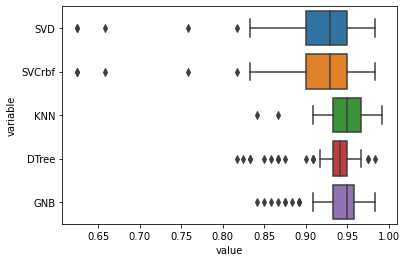

In [67]:
import seaborn as sns

dfaccuracy = pd.DataFrame.from_dict(accuracy)
sns.boxplot(x="value", y="variable", data=pd.melt(dfaccuracy))

    

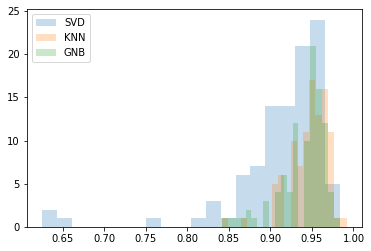

In [74]:
for k in ["SVD","KNN","GNB"]: plt.hist(accuracy[k], bins=20, label=k, alpha=0.25)
plt.legend()
plt.show()

They all pretty much agree within errors. The point here is that doing one train test split is picking a random sample from each of these distributions and sorting them. That's not a good way to figure out the best model!

#### Cross validation

In [123]:
from sklearn.model_selection import cross_val_score, KFold

X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.8, random_state=12345)

def clf_accuracy(clf,X,y):
    return accuracy_score(y, clf.predict(X))

kaccuracy = {k:[] for k in classifiers}
kaccuracy_std = {k:[] for k in classifiers}

Ncvs = 100
for i in range(Ncvs):
    kf = KFold(n_splits=5, shuffle=True, random_state=12345*i + 42)
    for k,v in classifiers.items(): 
        cvs = cross_val_score( v, X=X_train, y=y_train, cv=kf, scoring=clf_accuracy)
        kaccuracy[k].append( cvs.mean() )
        kaccuracy_std[k].append( cvs.std() )


<AxesSubplot:xlabel='value', ylabel='variable'>

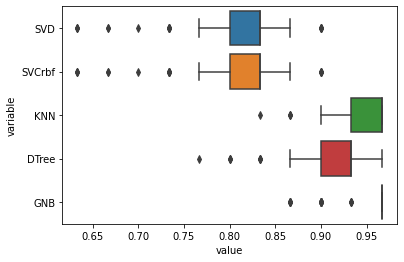

In [124]:
dfaccuracy = pd.DataFrame.from_dict(kaccuracy)
sns.boxplot(x="value", y="variable", data=pd.melt(dfaccuracy))

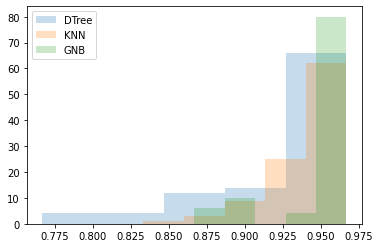

In [125]:
for k in ["DTree","KNN","GNB"]: plt.hist(kaccuracy[k], bins=5, label=k, alpha=0.25)
plt.legend()
plt.show()

So given this particular training data, CV suggests 3 of the algorithms are statistically equivalent. It's a good approximation to the results above. Note that I did CV many times! Just doing it once would give a list of numbers, which would show some particular order. We can't conclude from just one CV which classifier is the best.

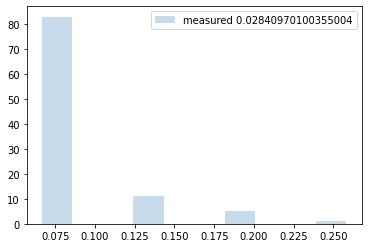

In [126]:
k="KNN"
import numpy as np

plt.hist(kaccuracy_std[k], bins=10, alpha=0.25, label="measured {}".format(np.array(kaccuracy[k]).std()) )
plt.legend();

The histogram shows the standard deviation of all the Cross Validations. i.e. Each 5-fold cross validation gives 5 accuracys cvs = [x,x,x,x,x]. The standard deviation, cvs.std(), for each shuffled cross validation is recorded and shown in this histogram. The actual standard deviation of the mean scores is 0.028 which is quite a bit lower. i.e. The estimate cvs.std() oversetimates the variance.

#### Leave one out

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.8, random_state=12345)

def clf_accuracy(clf,X,y):
    return accuracy_score(y, clf.predict(X))

kf = KFold(n_splits=len(y_train), shuffle=True, random_state=12345*i + 42)
for k,v in classifiers.items(): 
        cvs = cross_val_score( v, X=X_train, y=y_train, cv=kf, scoring=clf_accuracy)
        print( k, ":: Mean {:.3f}. STD: LOO {}, 5Fold {}, Actual {}".format( 
            cvs.mean(), 
            cvs.std(), 
            np.array(kaccuracy[k]).std(), 
            np.array(accuracy[k]).std()) )

SVD :: Mean 0.833. STD: LOO 0.3726779962499649, 5Fold 0.05605057240266747, Actual 0.06168918507773918
SVCrbf :: Mean 0.833. STD: LOO 0.3726779962499649, 5Fold 0.05605057240266747, Actual 0.06168918507773918
KNN :: Mean 0.967. STD: LOO 0.17950549357115012, 5Fold 0.02840970100355004, Actual 0.023863035105460586
DTree :: Mean 0.933. STD: LOO 0.24944382578492943, 5Fold 0.03909532509705533, Actual 0.033337916351605816
GNB :: Mean 0.967. STD: LOO 0.17950549357115012, 5Fold 0.029881246441353305, Actual 0.028280710937158404


Leave one out seems to greatly overestimate the variance!